# Домашняя работа №4 - прогнозирование временных рядов

**Срок сдачи:** 15 декабря 2017, 23:59 <br\>
Штраф за опоздание: -1 балл за каждый день

Файл с дз надо загрузить по [ссылке](https://www.dropbox.com/request/OUAxGl2fo2FZTHEdtEEh)<br/>
Постарайтесь назвать файл по следующему формату:** [ИАД-*{Номер}*] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **<br/>

Сопровождайте ваш код изображеними, комментариями и выводами. <br/>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.

В этом задании вам необходимо:

* Выбрать любой временной ряд, который вы будете прогнозировать; лучше взять ряд с месячным или квартальным разрешением, длиной от 100 отсчётов и не слишком простой (не выглядящий как константа или другая простая функция), иначе вам будет скучно его прогнозировать;
* Внести выбранный ряд в [таблицу](https://docs.google.com/spreadsheets/d/1NXTSQfIkAAHHnslrOVb2e0syP3Q3SHz0oZ_7qVor5Lg/edit?usp=sharing), убедившись, что никто другой его не взял - если несколько студентов будут прогнозировать один и тот же ряд, задача не будет засчитана никому из них;
* Проанализировать выбранный ряд по аналогии с примером, разбиравшимся на семинаре, и построить его прогноз на 3 года вперёд с помощью модели класса ARIMA.

Если вы не знаете, где можно брать ряды, вот несколько источников:

* https://datamarket.com/data/list/?q=cat:edb interval:month provider:tsdl
* http://sophist.hse.ru/hse/nindex.shtml
* https://stat.yandex.ru/
* https://www.quandl.com/browse?idx=database-browser_economic-data


In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import numpy as np
from itertools import product

plt.style.use('ggplot')
    
%matplotlib inline

plt.rcParams['figure.figsize'] = (14, 7)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import statsmodels
statsmodels.__version__

'0.8.0'

In [3]:
GS = pd.read_csv('EOD-GS.csv',',', 
                   index_col=['Date'], parse_dates=['Date'], dayfirst=True)
GS = pd.DataFrame(GS.Close)
GS.head()

FileNotFoundError: File b'EOD-GS.csv' does not exist

Будем анализировать данные на конец месяца:

In [4]:
GS = GS.resample('M', how = {'Close': 'first'}, closed='right', label='right')

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


In [5]:
GS.head()

,Close
Date,
1999-05-31,70.38
1999-06-30,64.19
1999-07-31,70.81
1999-08-31,62.81
1999-09-30,60.31


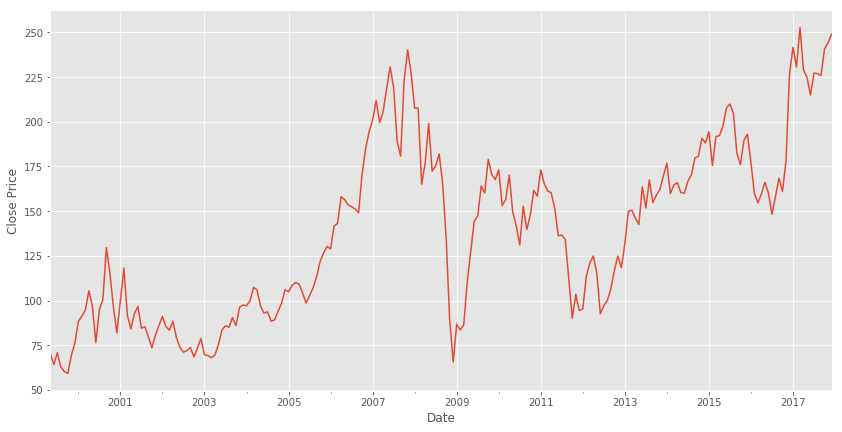

In [6]:
GS.Close.plot()
plt.ylabel('Close Price')

Далее идем по аналогии с семинарским примером.

Сначала проверим гипотезу о стационарсти ряда:

In [7]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GS.Close)[1])

Критерий Дики-Фуллера: p=0.361451


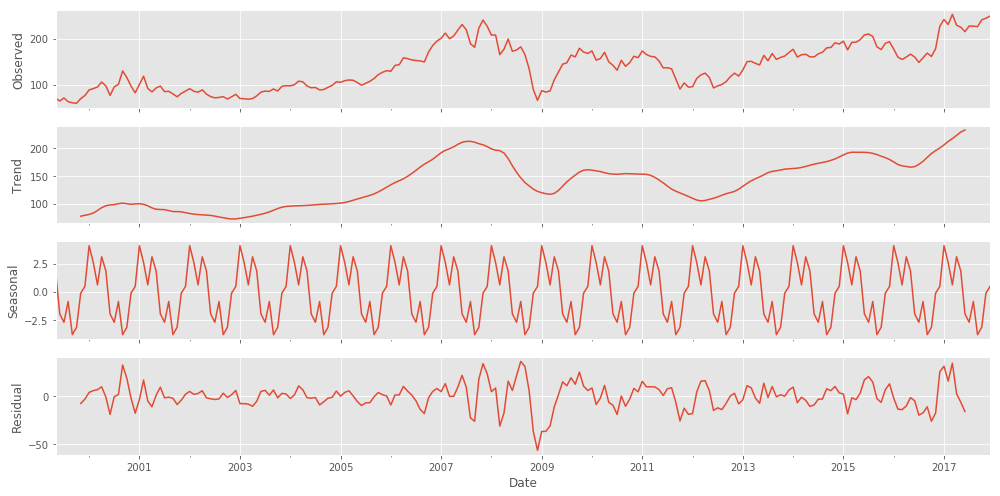

In [8]:
fig = sm.tsa.seasonal_decompose(GS.Close).plot()

Значение критерия Дики-Фуллера отвергает гипотезу о стационарсти ($p<1$), но тренд все еще присутствует.

### Стабилизация дисперсии

Теперь применим преобразование Бокса-Кокса для стабилизации дисперсии. Для этого найдем оптимальный $\lambda$.

Оптимальный параметр преобразования Бокса-Кокса: 0.291475
Критерий Дики-Фуллера: p=0.227296


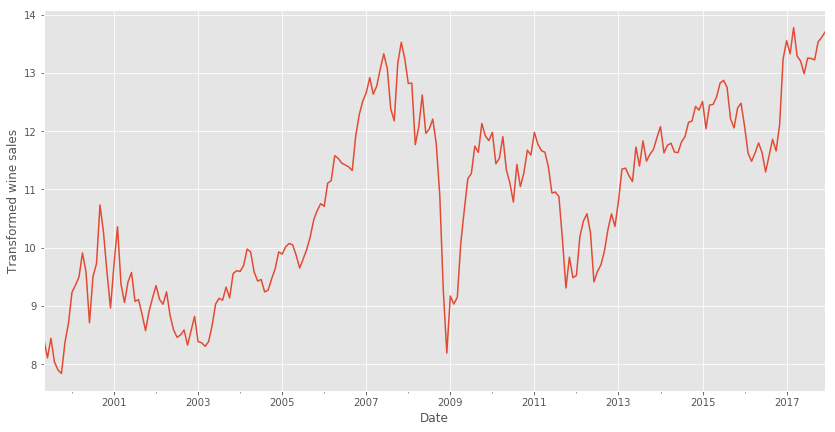

In [9]:
GS['Close_box'], lmbda = stats.boxcox(GS.Close)
GS.Close_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GS.Close_box)[1])

### Стационарность
Теперь для того, чтобы избавится от тренда попробуем сезонное дифференцирование: сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.006309


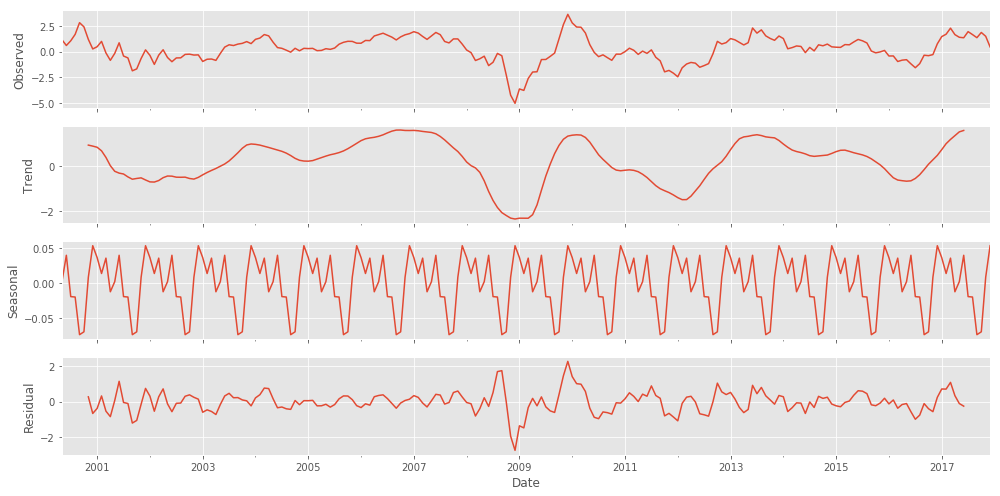

In [10]:
GS['Close_box_diff'] = GS.Close_box - GS.Close_box.shift(12)
fig = sm.tsa.seasonal_decompose(GS.Close_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GS.Close_box_diff[12:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — выраженного тренда больше нет. 

## Подбор параметров модели
Посмотрим на ACF и PACF полученного ряда:

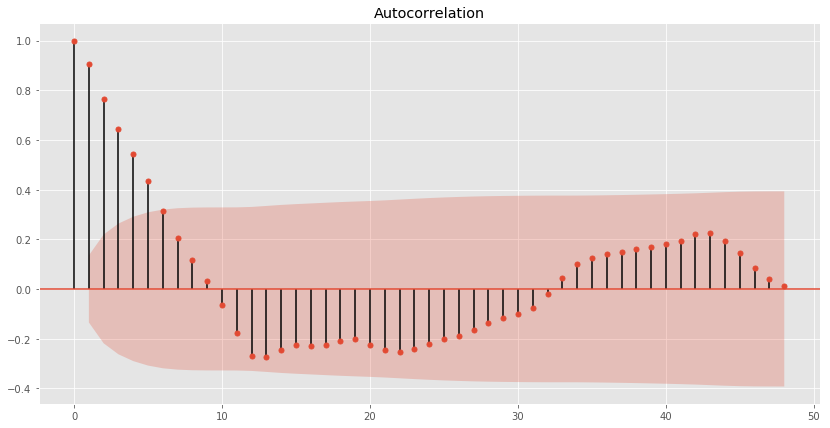

In [11]:
fig = sm.graphics.tsa.plot_acf(GS.Close_box_diff[13:].values.squeeze(), lags=48)

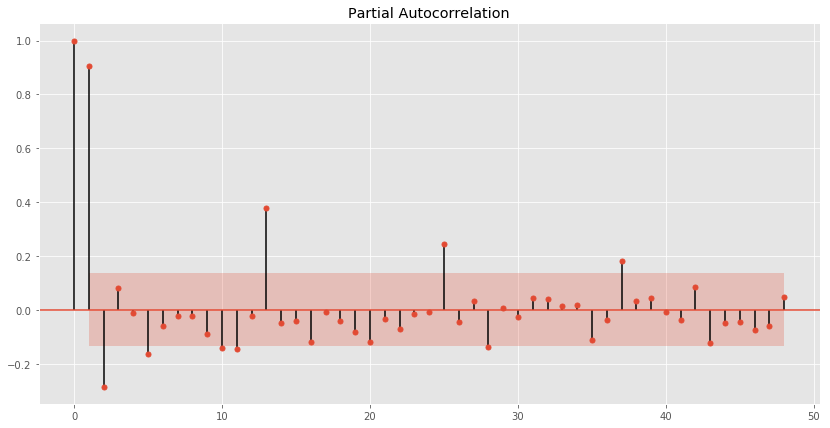

In [12]:
fig = sm.graphics.tsa.plot_pacf(GS.Close_box_diff[13:].values.squeeze(), lags=48)

### Начальное приближение

Начальные приближения: Q=1, q=2, P=1, p=4

* Q = 1, потому что на графике ACF наблюдается значимое значение на лаге 12 - это сезонность
* q = 2, потому что на графике ACF налюдается значимое значение на лаге 1 и 2
* P = 1, потому что на графике PACF наблюдается значимое значение на лаге 12 - это сезонность
* p = 2, потому что на графике PACF налюдается значимое значение на лаге 1 - 4

In [13]:
D=1 # Потому что мы сезонный сдвиг
d=1 # Потому что мы сделали обычный сдвиг на 1 шаг

p = 2
q = 2
P = 1
Q = 1


model = sm.tsa.statespace.SARIMAX(GS.Close_box, order=(p, d, q), 
                                seasonal_order=(P, D, Q, 4)).fit(disp=-1)
# 4 для квартальных данных

In [14]:
model.aic

232.2932273945047

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         Close_box   No. Observations:                  224
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 4)   Log Likelihood                -109.147
Date:                           Fri, 15 Dec 2017   AIC                            232.293
Time:                                   19:20:05   BIC                            256.175
Sample:                               05-31-1999   HQIC                           241.933
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5826      0.347      1.680      0.093      -0.097       1.262
ar.L2          0.3067      0.352      0.872      0.383      -0.383       0.996
ma.L1         -0.5070   5347.140  -9.48e-05      1.000   -1.05e+04    1.05e+04
ma.L2         -0.4930   2636.379     -0.000      1.000   -5167.700    5166.714
ar.S.L4        0.0686      0.074      0.927      0.354      -0.076       0.214
ma.S.L4       -0.9994      2.658     -0.376      0.707      -6.209       4.211
sigma2         0.1440    769.850      0.000      1.000   -1508.735    1509.023
===================================================================================
Ljung-Box (Q):                       26.33   Jarque-Bera (JB):                30.55
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.60
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Анализ остатков.

Критерий Стьюдента: p=0.638925
Критерий Дики-Фуллера: p=0.000000


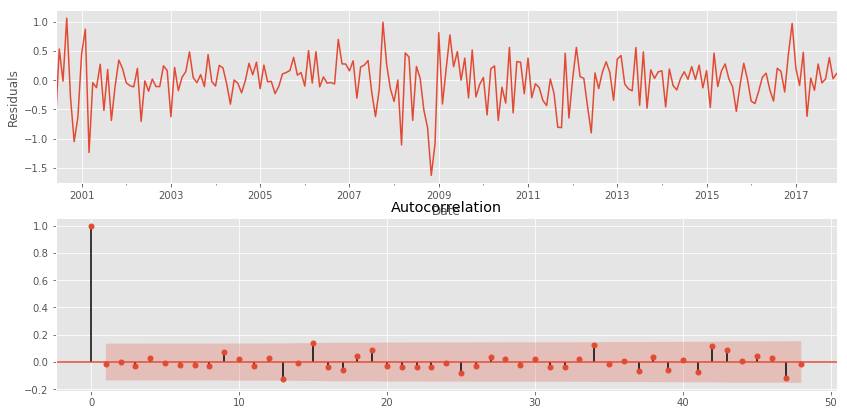

In [16]:
_, ax = plt.subplots(2,1)
model.resid[13:].plot(ax=ax[0])
ax[0].set_ylabel(u'Residuals')

fig = sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax[1])

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:].values, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Функция обратного преобразования Бокса-Кокса.

In [17]:
def invboxcox(w, lmbda=sm.tsa.stattools.adfuller(GS.Close_box)[1]):
    y = []
    if lmbda != 0:
        y = (w*lmbda + 1)**(1/lmbda)
    else:  
        y = np.exp(w)
    
    return y

Так выглядит прогноз:

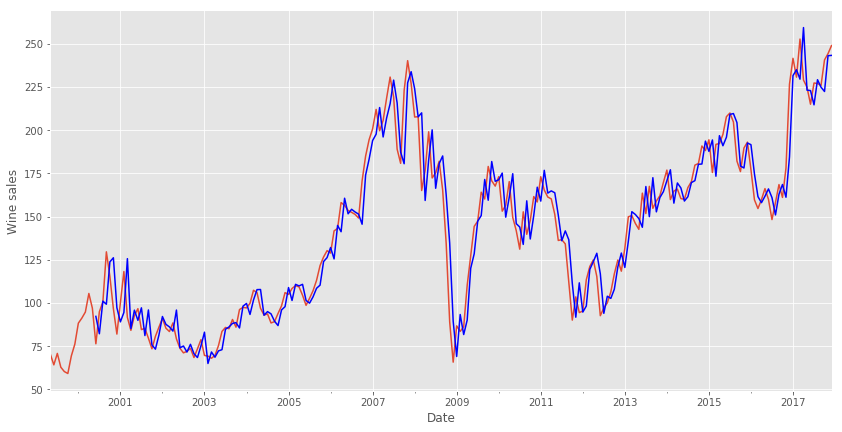

In [18]:
GS['model'] = invboxcox(model.fittedvalues, lmbda)
GS.Close.plot()
GS.model[13:].plot(color='b')
plt.ylabel('Wine sales')

## Перебор параметров

Найдем лучший набор параметров.

In [19]:
ps = range(0, 4)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)

parameters_list = product(ps, qs, Qs, Qs)

In [20]:
parameters_list = list(parameters_list)

In [21]:
%%time
results = []
best_aic = np.inf
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(GS.Close_box, order=(param[0], d, param[1]), 
                                 seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    #сохраняем лучшую модель, aic, параметры
    aic = model.aic
    if aic < best_aic:
        print('wrong parameters:', param)
        print('aic=:{}'.format(aic))
        best_aic = aic
        best_model = model
        results.append([param,aic])

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
aic=:243.12588299840627
wrong parameters: (0, 1, 0, 1)
aic=:241.743600590538
wrong parameters: (2, 0, 0, 1)
aic=:241.63479013125686
CPU times: user 18.2 s, sys: 250 ms, total: 18.4 s
Wall time: 13.6 s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
2  (2, 0, 0, 1)  241.634790
1  (0, 1, 0, 1)  241.743601
0  (0, 0, 0, 1)  243.125883


Лучшая модель:

In [23]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Close_box   No. Observations:                  224
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -116.817
Date:                            Fri, 15 Dec 2017   AIC                            241.635
Time:                                    19:20:19   BIC                            255.281
Sample:                                05-31-1999   HQIC                           247.143
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1288      0.060      2.157      0.031       0.012       0.246
ar.L2         -0.1158      0.062     -1.883      0.060      -0.236       0.005
ma.S.L12      -0.9517      0.134     -7.109      0.000      -1.214      -0.689
sigma2         0.1564      0.020      7.685      0.000       0.117       0.196
===================================================================================
Ljung-Box (Q):                       29.19   Jarque-Bera (JB):                21.58
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.48
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Стьюдента: p=0.813043
Критерий Дики-Фуллера: p=0.000000


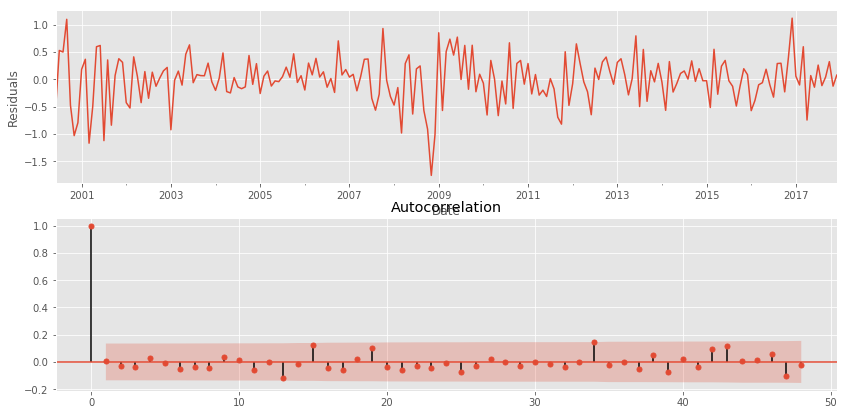

In [24]:
_, ax = plt.subplots(2,1)
model.resid[13:].plot(ax=ax[0])
ax[0].set_ylabel(u'Residuals')

fig = sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax[1])

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:].values, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

## Прогноз

Теперь выполним прогноз на три года вперед.

In [25]:
from pandas.tseries.offsets import MonthBegin

In [26]:
GS.shape

(224, 4)

In [27]:
GS.head()

,Close,Close_box,Close_box_diff,model
Date,,,,
1999-05-31,70.38,8.423701,NaN,1.000000
1999-06-30,64.19,8.109830,NaN,70.380003
1999-07-31,70.81,8.444766,NaN,64.189999
1999-08-31,62.81,8.036955,NaN,70.809999
1999-09-30,60.31,7.901992,NaN,183.708088


In [28]:
best_model.predict(start=224, end=259)

2018-01-31    13.878206
2018-02-28    13.861536
2018-03-31    13.836660
2018-04-30    13.946738
2018-05-31    13.919547
2018-06-30    13.803063
2018-07-31    13.818735
2018-08-31    13.883650
2018-09-30    13.828356
2018-10-31    13.845775
2018-11-30    13.982093
2018-12-31    14.007293
2019-01-31    14.168215
2019-02-28    14.157510
2019-03-31    14.135278
2019-04-30    14.245005
2019-05-31    14.217463
2019-06-30    14.100974
2019-07-31    14.116687
2019-08-31    14.181608
2019-09-30    14.126309
2019-10-31    14.143728
2019-11-30    14.280045
2019-12-31    14.305246
2020-01-31    14.466168
2020-02-29    14.455463
2020-03-31    14.433231
2020-04-30    14.542958
2020-05-31    14.515416
2020-06-30    14.398927
2020-07-31    14.414640
2020-08-31    14.479561
2020-09-30    14.424262
2020-10-31    14.441681
2020-11-30    14.577998
2020-12-31    14.603199
Freq: M, dtype: float64

In [29]:
pred = best_model.predict(start=224, end=259).to_frame('prediction')
pred.loc[:, 'prediction'] = invboxcox(pred.loc[:,'prediction'],lmbda)

In [30]:
pred.head()

,prediction
2018-01-31,257.891680
2018-02-28,257.040531
2018-03-31,255.774155
2018-04-30,261.411652
2018-05-31,260.010998


In [31]:
GS.head()

,Close,Close_box,Close_box_diff,model
Date,,,,
1999-05-31,70.38,8.423701,NaN,1.000000
1999-06-30,64.19,8.109830,NaN,70.380003
1999-07-31,70.81,8.444766,NaN,64.189999
1999-08-31,62.81,8.036955,NaN,70.809999
1999-09-30,60.31,7.901992,NaN,183.708088


Так выглядит прогноз:

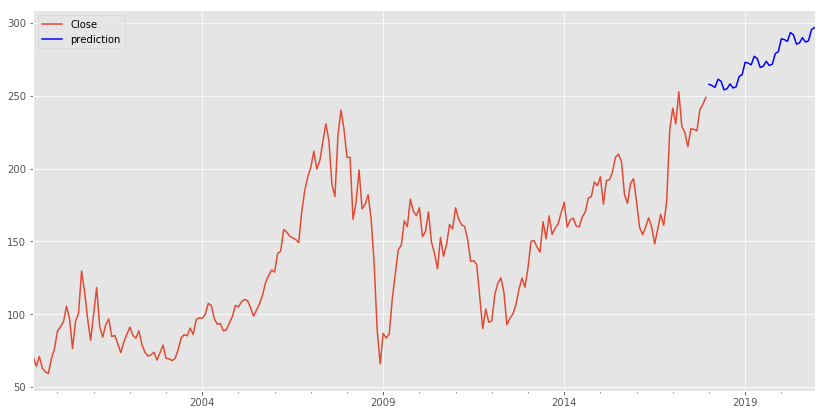

In [32]:
fig, ax = plt.subplots(1,1)

GS_pred = GS.copy()
GS_pred = GS_pred.append(pred)
GS_pred.plot(y='Close', ax=ax)
GS_pred.plot(y='prediction', ax=ax, c='b')